In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [ ]:
# CẤU HÌNH ĐƯỜNG DẪN
# Thay đổi đường dẫn này trỏ đến thư mục train của bạn
train_dir = 'Dataset/train' 

# Các lớp cần tăng cường (chỉ chọn lớp ít dữ liệu)
classes_to_augment = ['Angry', 'Surprise']

# Số lượng ảnh mục tiêu cho mỗi lớp (dựa trên biểu đồ cũ của bạn, lớp Happy/Neutral có khoảng 600 ảnh)
target_count = 2500 

# CẤU HÌNH AUGMENTATION
# Chỉ chọn những biến đổi hợp lý với khuôn mặt
datagen = ImageDataGenerator(
    rotation_range=15,      # Xoay nhẹ (đừng xoay quá nhiều, mặt người không lộn ngược)
    width_shift_range=0.1,  # Dịch chuyển ngang
    height_shift_range=0.1, # Dịch chuyển dọc
    shear_range=0.1,        # Biến dạng cắt kéo
    zoom_range=0.1,         # Phóng to/thu nhỏ
    horizontal_flip=True,   # Lật ngang (quan trọng với khuôn mặt)
    fill_mode='nearest'     # Lấp đầy khoảng trống
)

def augment_class(class_name):
    class_dir = os.path.join(train_dir, class_name)
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]
    
    current_count = len(images)
    print(f"Lớp '{class_name}': Hiện có {current_count} ảnh.")
    
    if current_count >= target_count:
        print(f" -> Đã đủ dữ liệu, không cần tạo thêm.")
        return

    # Tính toán số lượng ảnh cần sinh thêm
    needed_images = target_count - current_count
    print(f" -> Cần sinh thêm {needed_images} ảnh...")

    # Tạo ảnh mới
    generated_count = 0
    while generated_count < needed_images:
        # Lặp qua từng ảnh gốc để sinh ảnh mới
        for img_path in images:
            if generated_count >= needed_images:
                break
                
            try:
                # Load ảnh và chuyển thành mảng
                img = load_img(img_path) 
                x = img_to_array(img)
                x = x.reshape((1,) + x.shape) # Reshape thành (1, height, width, channels)

                # Sinh ảnh ngẫu nhiên từ ảnh gốc này
                # save_to_dir: Nơi lưu ảnh
                # save_prefix: Tiền tố tên file (ví dụ: aug_Angry_01.png)
                for batch in datagen.flow(x, batch_size=1, 
                                          save_to_dir=class_dir, 
                                          save_prefix='aug_' + class_name, 
                                          save_format='jpg'):
                    generated_count += 1
                    break # Chỉ sinh 1 ảnh mỗi lần loop để đa dạng hóa
            except Exception as e:
                print(f"Lỗi với ảnh {img_path}: {e}")

    print(f" -> Hoàn tất! Đã thêm {generated_count} ảnh vào thư mục '{class_name}'.")

# CHẠY QUÁ TRÌNH
print("Bắt đầu quá trình Data Augmentation cho các lớp thiểu số...")
for cls in classes_to_augment:
    augment_class(cls)
print("Kết thúc.")

Bắt đầu quá trình Data Augmentation cho các lớp thiểu số...
Lớp 'Angry': Hiện có 2500 ảnh.
 -> Đã đủ dữ liệu, không cần tạo thêm.
Lớp 'Surprise': Hiện có 2500 ảnh.
 -> Đã đủ dữ liệu, không cần tạo thêm.
Kết thúc.


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os

In [ ]:
# ==========================================
# 1. CẤU HÌNH ĐƯỜNG DẪN (Bạn sửa ở đây)
# ==========================================
# Đường dẫn đến folder bạn vừa chia xong
# Ví dụ: '/kaggle/working/Split_Dataset' hoặc đường dẫn trên máy bạn
base_dir = 'Dataset' 

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
# test_dir để dành dùng sau khi train xong

IMG_SIZE = 224  # Kích thước chuẩn cho MobileNetV2
BATCH_SIZE = 32

# ==========================================
# 2. CHUẨN BỊ DỮ LIỆU (DATA LOADERS)
# ==========================================
# Augmentation nhẹ nhàng cho tập train
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,)

print("--- Đang load dữ liệu ---")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb', # Quan trọng: Ảnh màu
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

# Tự động lấy số lượng lớp (5 lớp)
num_classes = train_generator.num_classes
print(f"--> Đã tìm thấy {num_classes} loại cảm xúc: {list(train_generator.class_indices.keys())}")

# ==========================================
# 3. XÂY DỰNG MODEL (TRANSFER LEARNING)
# ==========================================
# Tải MobileNetV2 đã học sẵn trên ImageNet, bỏ phần đầu
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Đóng băng (Freeze) các lớp của base_model để không train lại
base_model.trainable = False

# Thêm phần đầu (Head) mới của riêng bài toán này
x = base_model.output
x = GlobalAveragePooling2D()(x) # Thay thế Flatten, tốt hơn cho Transfer Learning
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x) # Chống overfitting
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ==========================================
# 4. THIẾT LẬP CALLBACKS
# ==========================================
checkpoint = ModelCheckpoint(
    'Best_Emotion_MobileNetV2.keras', 
    monitor='val_accuracy', 
    save_best_only=True, 
    mode='max', 
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True, 
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    min_lr=1e-6, 
    verbose=1
)

# ==========================================
# 5. BẮT ĐẦU TRAIN
# ==========================================
print("\n🚀 Bắt đầu training...")
history = model.fit(
    train_generator,
    epochs=30, # Để 30-50 epoch, early_stopping sẽ tự dừng nếu cần
    validation_data=val_generator,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

print("✅ Hoàn tất giai đoạn 1 của Training!")
# 1. Mở khóa base model
base_model.trainable = True

# 2. Chỉ để các lớp cuối cùng train được (Freeze các lớp đầu)
# MobileNetV2 có khoảng 155 lớp, ta sẽ đóng băng 100 lớp đầu
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# 3. Compile lại với Learning Rate RẤT NHỎ (quan trọng)
model.compile(optimizer=Adam(learning_rate=1e-5), # Giảm 100 lần so với lúc đầu
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 4. Train tiếp (Fine-tuning)
print("Bắt đầu Fine-tuning...")
history_fine = model.fit(
    train_generator,
    epochs=20, # Train thêm 20 epoch nữa
    validation_data=val_generator,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

print("✅ Hoàn tất Training!")



--- Đang load dữ liệu ---
Found 13196 images belonging to 5 classes.
Found 2136 images belonging to 5 classes.
--> Đã tìm thấy 5 loại cảm xúc: ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']

🚀 Bắt đầu training...
Epoch 1/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.3965 - loss: 1.4637
Epoch 1: val_accuracy improved from None to 0.51592, saving model to Best_Emotion_MobileNetV2.keras
413/413 ━━━━━━━━━━━━━━━━━━━━ 253s 604ms/step - accuracy: 0.4551 - loss: 1.3194 - val_accuracy: 0.5159 - val_loss: 1.1780 - learning_rate: 0.0010
Epoch 2/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.5337 - loss: 1.1411
Epoch 2: val_accuracy improved from 0.51592 to 0.53839, saving model to Best_Emotion_MobileNetV2.keras
413/413 ━━━━━━━━━━━━━━━━━━━━ 190s 461ms/step - accuracy: 0.5383 - loss: 1.1360 - val_accuracy: 0.5384 - val_loss: 1.1142 - learning_rate: 0.0010
Epoch 3/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.5686 - loss: 1.0824
Epoch 3: val_accuracy improv

In [2]:
# save model
model.save('model/Emotion_model_1.keras')

NameError: name 'model' is not defined

In [4]:
model = tf.keras.models.load_model(r'D:\Projects\EmotionDetection\LearnData\model\Best_Emotion_MobileNetV2.keras')

In [5]:
import matplotlib.pyplot as plt
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


NameError: name 'history' is not defined

# TEST MODEL

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

# ==========================================
# 1. CẤU HÌNH (Thay đổi đường dẫn tại đây)
# ==========================================
TEST_DATA_DIR = 'Dataset/test'  # Đường dẫn đến thư mục chứa 5 folder con của tập test
MODEL_PATH = 'model/Best_Emotion_MobileNetV2.keras'           # Đường dẫn đến file model đã train (.h5 hoặc .keras)
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# ==========================================
# 2. CHUẨN BỊ DỮ LIỆU TEST
# ==========================================
print("Đang tải dữ liệu test...")

# Lưu ý: Nếu khi train bạn có chia ảnh cho 255 (rescale=1./255) thì ở đây cũng phải làm y hệt.
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) 

test_generator = test_datagen.flow_from_directory(
    TEST_DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical', # Hoặc 'sparse' tùy vào cách bạn compile model, thường là categorical
    color_mode='rgb',
    shuffle=False             # QUAN TRỌNG: Không trộn dữ liệu để so sánh đúng nhãn
)

# Lấy danh sách tên các cảm xúc (Labels)
class_labels = list(test_generator.class_indices.keys()) # ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']
print(f"Các lớp cảm xúc tìm thấy: {class_labels}")

# ==========================================
# 3. LOAD MODEL VÀ DỰ ĐOÁN
# ==========================================
print(f"Đang load model từ: {MODEL_PATH} ...")
model_test = load_model(MODEL_PATH)


print("Đang thực hiện dự đoán trên tập test...")
# Dự đoán toàn bộ tập test
predictions = model_test.predict(test_generator, verbose=1)

Đang tải dữ liệu test...
Found 2942 images belonging to 5 classes.
Các lớp cảm xúc tìm thấy: ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']
Đang load model từ: model/Best_Emotion_MobileNetV2.keras ...
Đang thực hiện dự đoán trên tập test...
92/92 ━━━━━━━━━━━━━━━━━━━━ 55s 590ms/step



ĐỘ CHÍNH XÁC (ACCURACY): 74.27%

Báo cáo chi tiết từng lớp:
              precision    recall  f1-score   support

       Angry       0.88      0.71      0.79       591
       Happy       0.82      0.88      0.85       561
     Neutral       0.59      0.74      0.66       605
         Sad       0.63      0.70      0.66       591
    Surprise       0.91      0.69      0.78       594

    accuracy                           0.74      2942
   macro avg       0.77      0.74      0.75      2942
weighted avg       0.77      0.74      0.75      2942



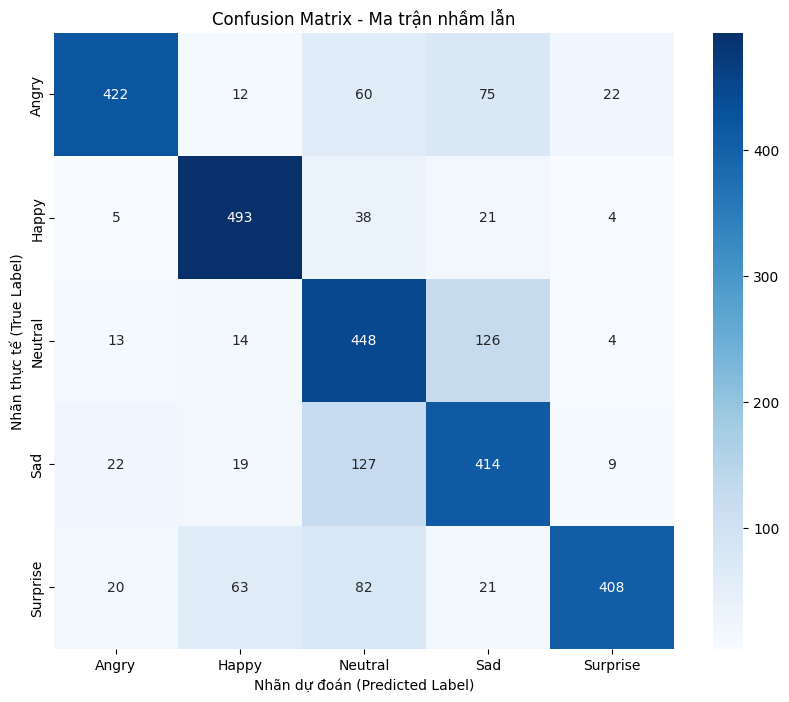

In [10]:

# Chuyển đổi từ xác suất sang nhãn (index có giá trị cao nhất)
y_pred = np.argmax(predictions, axis=1)

# Lấy nhãn thực tế từ thư mục
y_true = test_generator.classes

# ==========================================
# 4. ĐÁNH GIÁ KẾT QUẢ
# ==========================================

# --- A. Tính độ chính xác tổng thể ---
test_loss, test_acc = model_test.evaluate(test_generator, verbose=0)
print("\n" + "="*40)
print(f"ĐỘ CHÍNH XÁC (ACCURACY): {test_acc * 100:.2f}%")
print("="*40 + "\n")

# --- B. Báo cáo chi tiết (Classification Report) ---
print("Báo cáo chi tiết từng lớp:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# --- C. Vẽ Ma trận nhầm lẫn (Confusion Matrix) ---
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, 
            yticklabels=class_labels)
plt.title('Confusion Matrix - Ma trận nhầm lẫn')
plt.ylabel('Nhãn thực tế (True Label)')
plt.xlabel('Nhãn dự đoán (Predicted Label)')
plt.show()